# Toxic Comment Classification Using Machine Learning on Social Media Data

## 1. Install & Import Packages

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Enable inline plots
%matplotlib inline

# Utilities
import os
import re
import time
import string
import shutil
import zipfile
import random
from collections import Counter
from functools import partial

# Data handling
import pandas as pd
import numpy as np

# Multiprocessing
import multiprocessing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Genetic Algorithm (DEAP)
from deap import base, creator, tools, algorithms
import random

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK data (only needed once per runtime)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## 2. Load CSV File

The dataset contains 4 zips file: sample_submission.csv.zip, test.csv.zip, test_labels.csv.zip, and train.csv.zip.
You can find [here](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data).



In [ ]:
# Run google drive permission
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directory path in Google Drive following the path MyDrive/CPP/Spring2025/CS4210/project
base_path = "/content/drive/MyDrive/CPP/Spring2025/CS4210/project"
output_dir = "toxic_comment_dataset"
os.makedirs(output_dir, exist_ok=True)

# List of zip files on the folder project
zip_files = ["train.csv.zip", "test.csv.zip", "sample_submission.csv.zip", "test_labels.csv.zip"]

# Unzip all
for file in zip_files:
    zip_path = os.path.join(base_path, file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

In [ ]:
# Load CSVs into pandas
train_df = pd.read_csv(os.path.join(output_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(output_dir, "test.csv"))
submission_df = pd.read_csv(os.path.join(output_dir, "sample_submission.csv"))
test_labels_df = pd.read_csv(os.path.join(output_dir, "test_labels.csv"))

# Remove rows with -1 in any label
test_labels_df = test_labels_df[test_labels_df.iloc[:, 1:].ne(-1).all(axis=1)]

# Merge labels with test_df to align comments and labels
test_df_labeled = test_df.merge(test_labels_df, on="id")

# Use this for evaluation later
test_comments_labeled = test_df_labeled["comment_text"]
y_test = test_df_labeled[train_df.columns[2:]]  # from 'toxic' onward

# Use 30k random samples for training to save memory
train_df = train_df.sample(30000, random_state=42)

# Check training data
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In [ ]:
# Check data
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
95207,fe8b3226122c6c13,"""\nI'll add it once more details surface. Rig...",0,0,0,0,0,0
119245,7d75c386c2f50cad,Table in need of reconstruction \n\nThe tables...,0,0,0,0,0,0
127958,ac60009a90734c13,""": """"multiple mainstreams"""" for the author's p...",0,0,0,0,0,0
58894,9dbb6cac0097f416,Mary Poppins Should Be There\nBefore I begin I...,0,0,0,0,0,0
112300,58b461f8d6b1163a,"""\nYou are mistaken. The Johnson School is no ...",0,0,0,0,0,0


## 3. Exploratory Data Analysis (EDA)

### 3.1 Toxic Category Distribution

#### 3.1.1 Data set Visualization

Count comments in each toxic category

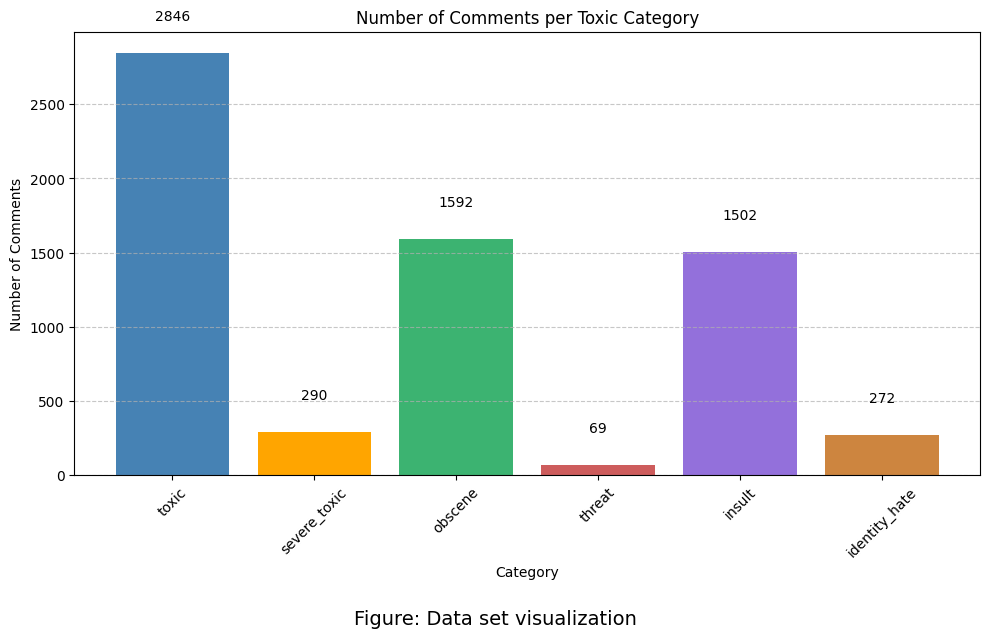

In [ ]:
# Count how many comments are labeled as each category
category_counts = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

#Set custom color for each bar
colors = ['steelblue', 'orange', 'mediumseagreen', 'indianred', 'mediumpurple', 'peru']

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, color=colors)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 200, int(yval), ha='center', va='bottom', fontsize=10)

# Add labels, grid, caption
plt.title("Number of Comments per Toxic Category")
plt.ylabel("Number of Comments")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.figtext(0.5, -0.05, "Figure: Data set visualization", wrap=True, ha='center', fontsize=14)

plt.tight_layout()
plt.show()

#### 3.1.2 Percentage of Comments in each toxic category

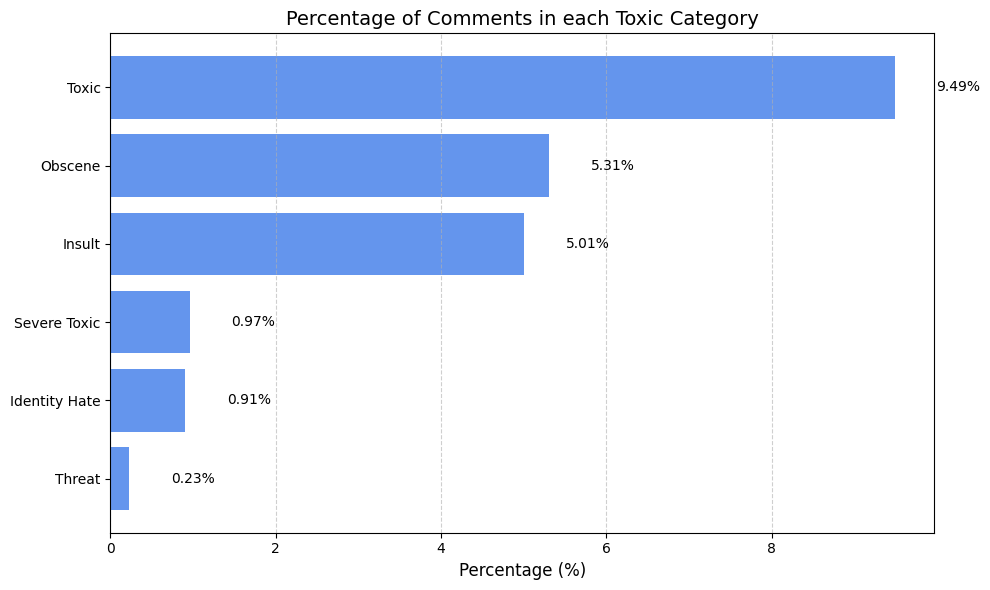

In [ ]:
# Count each toxic category
category_counts = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
total_comments = len(train_df)

# Calculate percentage
category_percent = (category_counts / total_comments) * 100

# Sort (for cleaner layout)
category_percent = category_percent.sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(category_percent.index.str.replace('_', ' ').str.title(), category_percent.values, color='cornflowerblue')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center', fontsize=10)

# Labels and title
plt.xlabel("Percentage (%)", fontsize=12)
plt.title("Percentage of Comments in each Toxic Category", fontsize=14)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


### 3.2 Correlation Heatmap Between Toxic Categories


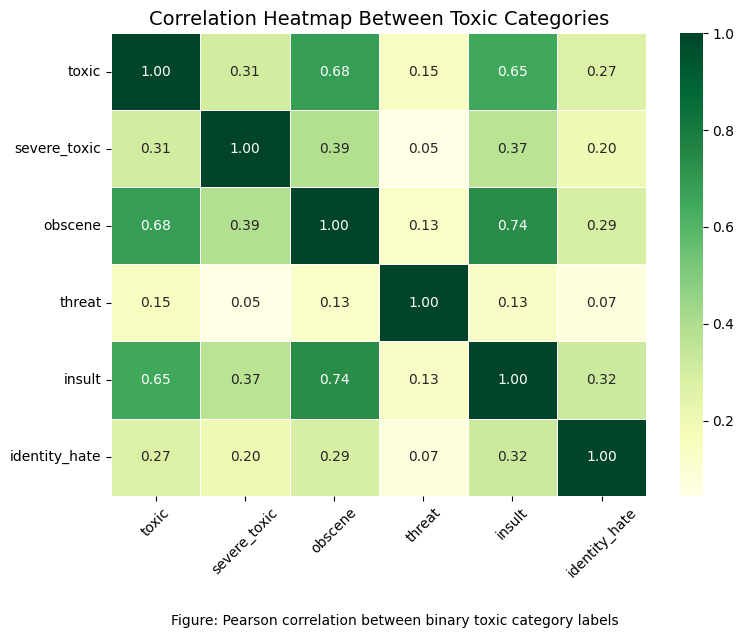

In [ ]:
# Select only the label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Compute the correlation matrix
correlation = train_df[label_cols].corr()

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='YlGn', fmt=".2f", linewidths=0.5, linecolor='white')

# Titles and labels
plt.title("Correlation Heatmap Between Toxic Categories", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Caption
plt.figtext(0.5, -0.05, "Figure: Pearson correlation between binary toxic category labels", wrap=True, ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3.3 Additional Insights: Lengths & Multi-Labels


#### 3.3.1 Length of Comments

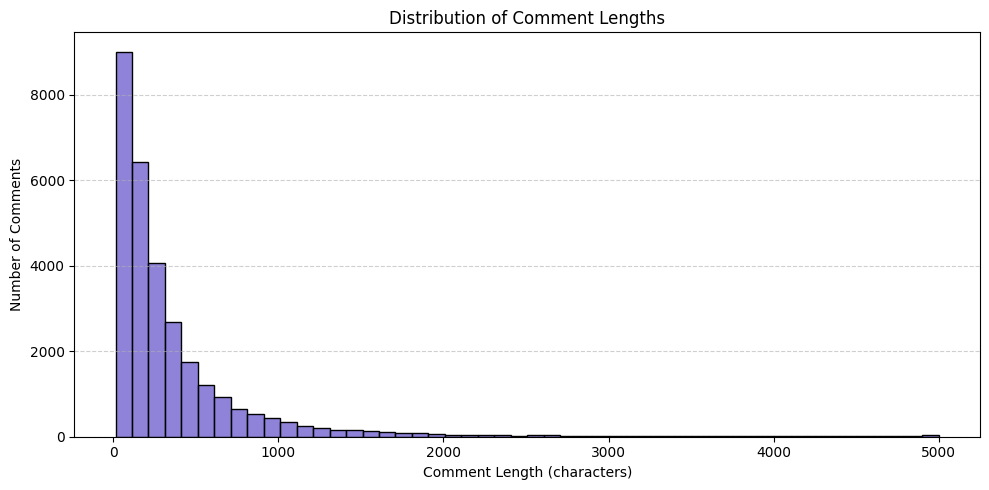

In [ ]:
# Add a new column for comment lengths
train_df['comment_length'] = train_df['comment_text'].astype(str).apply(len)

# Plot histogram of comment lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_df['comment_length'], bins=50, kde=False, color='slateblue')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Number of Comments")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### 3.3.2 Label Overlap Counts (Multi-label distribution)

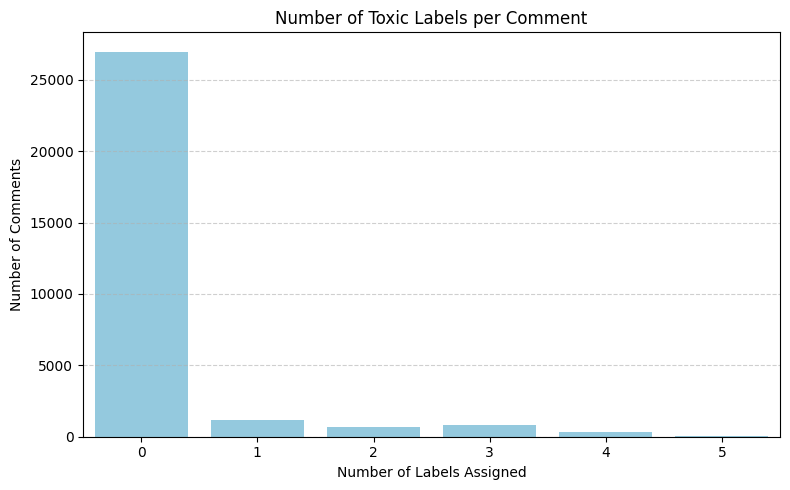

In [ ]:
# Count how many toxic labels each comment has
train_df['num_labels'] = train_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1)

# Bar chart of overlap count
plt.figure(figsize=(8, 5))
sns.countplot(x='num_labels', data=train_df, color='skyblue')
plt.title("Number of Toxic Labels per Comment")
plt.xlabel("Number of Labels Assigned")
plt.ylabel("Number of Comments")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### 3.3.3 Pie Chart of Single-Label vs Multi-Label

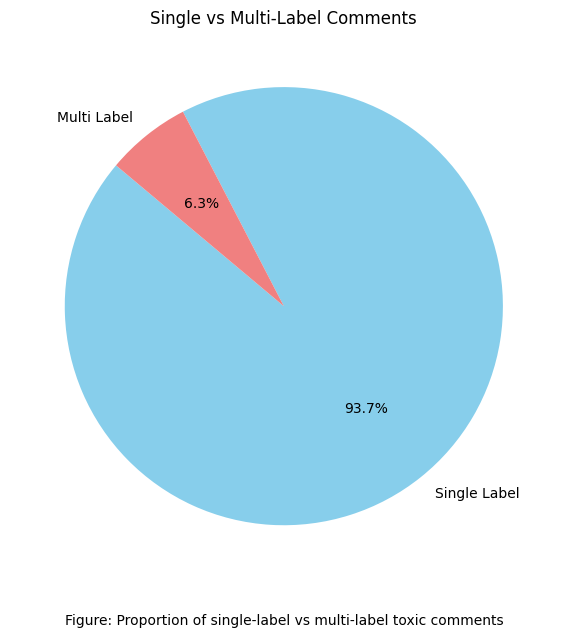

In [ ]:
# Binary split: single vs multi label
train_df['is_multi'] = train_df['num_labels'] > 1
label_split = train_df['is_multi'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_split, labels=["Single Label", "Multi Label"], autopct='%1.1f%%', colors=["skyblue", "lightcoral"], startangle=140)
plt.title("Single vs Multi-Label Comments")
plt.tight_layout()
plt.figtext(0.5, -0.05, "Figure: Proportion of single-label vs multi-label toxic comments", wrap=True, ha='center', fontsize=10)

plt.show()

#### Exploratory Data Analysis (EDA) Summary

Through EDA, we explored several key insights about the structure and distribution of the toxic comment dataset:

- **Category Imbalance:**
The majority of toxic comments are labeled as "toxic", followed by "obscene" and "insult". Less frequent categories include "threat", "severe_toxic", and "identity_hate", which may impact model learning due to class imbalance.
- **Multi-label Distribution:** Most comments (over 93%) contain only one toxic label, while the remaining are multi-labeled. This shows that although the task is multi-label classification, the dataset is heavily skewed toward single-label cases.
- **Label Correlation:** A correlation heatmap revealed strong co-occurrence between "toxic", "obscene", and "insult". These categories tend to overlap, suggesting potential shared patterns that models can learn from.
- **Comment Lengths:** The distribution of comment lengths is right-skewed, with the majority of comments under 500 characters. This highlights that padding/truncation will be needed during preprocessing to ensure uniform input sizes.

- **Text Distribution by Percentage:** When viewed by percentage, only around 10% of the dataset contains any toxic labels at all — which reinforces the class imbalance challenge.

## 4. Text Cleaning & Preprocessing

- Lowercase

- Remove links, punctuation, stopwords

- lemmatization or stemming

- Store in a new column like clean_text

In [ ]:
#Clean and preprocess comment text
print("Cleaning text...")
start_time = time.time()

stop_words = set(stopwords.words('english')) #set stop_words = common words in english
stemmer = SnowballStemmer("english")  #adjust the words into base form

def clean_text(text):
    text = text.lower() #convert to lower case
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) #remove links
    text = ''.join(ch for ch in text if ch not in string.punctuation) #remove punctuation
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  #adjust to base form if word not in stop_words
    return ' '.join(tokens) #return cleaned comment text

#Apply cleaning
train_df["clean_comment"] = train_df["comment_text"].astype(str).apply(clean_text)
test_df_labeled["clean_comment"] = test_df_labeled["comment_text"].astype(str).apply(clean_text)
test_df["clean_comment"] = test_df["comment_text"].astype(str).apply(clean_text) # For submission

#time it takes
end_time = time.time()
print(f"Finished cleaning in {end_time - start_time:.2f} seconds.")

Cleaning text...
Finished cleaning in 139.92 seconds.


## 5. Data Visualization (of text)

- Generate word clouds (toxic vs non-toxic)

- Visualize frequent terms

- Plot text length distributions

In [ ]:
#Split the data
toxic_comments = train_df[train_df['toxic'] == 1]['clean_comment']
non_toxic_comments = train_df[train_df['toxic'] == 0]['clean_comment']

# Generate word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

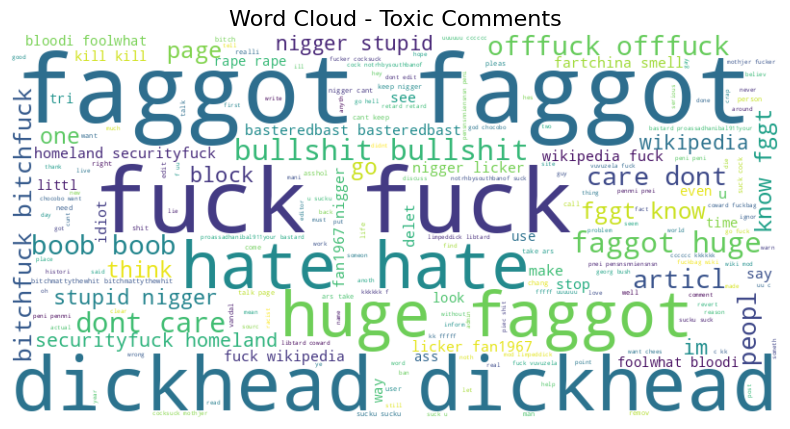

In [ ]:
generate_wordcloud(toxic_comments, "Word Cloud - Toxic Comments") #generate wordcloud for toxic comment

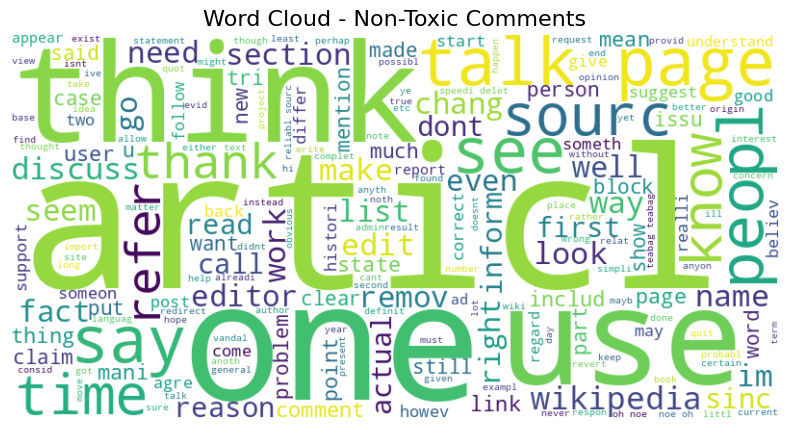

In [ ]:
generate_wordcloud(non_toxic_comments, "Word Cloud - Non-Toxic Comments") #generate wordcloud for non toxic comment

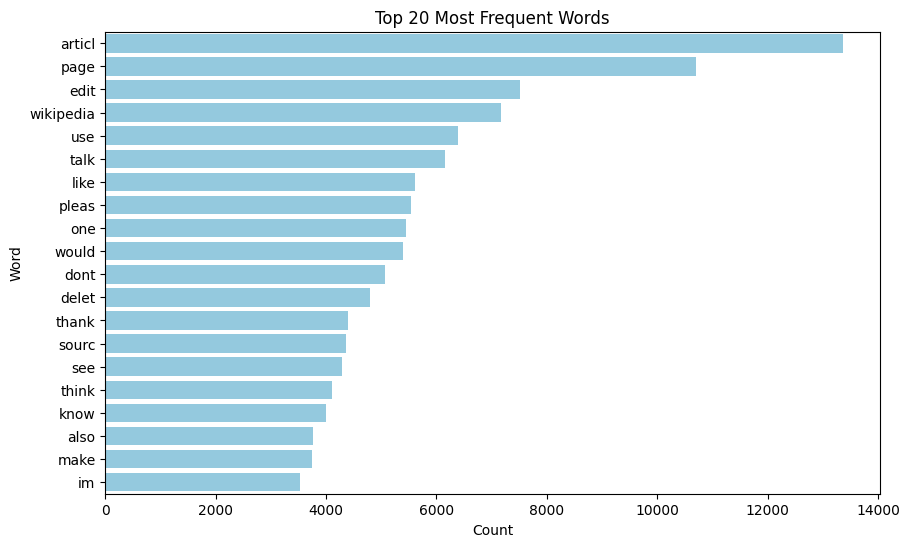

In [ ]:
# Get top 20 most common words in all comments
all_words = ' '.join(train_df['clean_comment']).split()
common_words = Counter(all_words).most_common(20)

# Convert to DataFrame for plotting
freq_df = pd.DataFrame(common_words, columns=['word', 'count'])

#Generate Most Frequent Words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=freq_df, color='skyblue')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

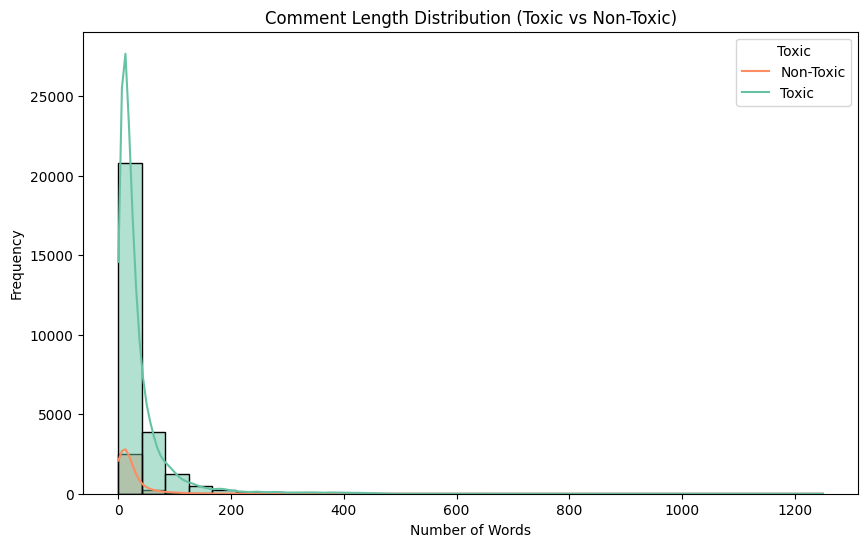

In [ ]:
# Add a new column with comment lengths
train_df["text_length"] = train_df["clean_comment"].apply(lambda x: len(x.split()))

# Generate Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x="text_length", hue="toxic", bins=30, kde=True, palette='Set2')
plt.title("Comment Length Distribution (Toxic vs Non-Toxic)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(title="Toxic", labels=["Non-Toxic", "Toxic"])
plt.show()

## 6. Text Processing (Vectorization)

In [ ]:
print("Extracting features...")
start_time = time.time()

# Process training text
vectorizer = TfidfVectorizer(max_features=30000)
X = vectorizer.fit_transform(train_df["clean_comment"])
y = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Merge test comments with labels
test_df_labeled = test_df.merge(test_labels_df, on="id")

# Process testing text
X_test_submit = vectorizer.transform(test_df["clean_comment"])        # for submission

# Clean the merged test comments (if not already cleaned)
test_df_labeled["clean_comment"] = test_df_labeled["comment_text"].astype(str).apply(clean_text)

# Vectorize the cleaned test comments
X_test_eval = vectorizer.transform(test_df_labeled["clean_comment"])

# Filter out rows with invalid (-1) labels
valid_rows = ~(test_df_labeled[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] == -1).any(axis=1)

# Apply the filtering
X_test_filtered = X_test_eval[valid_rows.values]
y_test = test_df_labeled.loc[valid_rows, ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Time it
end_time = time.time()
print(f"Finished extracting in {end_time - start_time:.2f} seconds.")

Extracting features...
Finished extracting in 41.27 seconds.


## 7. Train/Test Split

In [ ]:
print("Splitting data...")

#split data into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Splitting data...
Training set: (24000, 30000) (24000, 6)
Validation set: (6000, 30000) (6000, 6)


## 8. Model Training
Including Naive Bayes, Decision Tree, KNN, ANNs, Genetic Algorithm

### 8.1 Decision Tree Classifier Implementation

In [ ]:
# Initialize the model
dt_model = OneVsRestClassifier(DecisionTreeClassifier())

# Start timing
start_time = time.time()

# Train
print("Training Decision Tree model...")
dt_model.fit(X_train, y_train)

# Predict
dt_predictions = dt_model.predict(X_val)

# End timing
end_time = time.time()
training_duration = (end_time - start_time) / 60  # minutes

# Evaluate
accuracy = accuracy_score(y_val, dt_predictions) * 100
print(f"Accuracy score for Decision Tree: {accuracy:.2f}%")
print(f"Training time: {training_duration:.2f} minutes")

# Classification report
for i, label in enumerate(y_train.columns):
    print(f"\nClassification report for label: {label}")
    print(classification_report(y_val.iloc[:, i], dt_predictions[:, i], zero_division = 0))

# Confusion matrix per label
print("\nConfusion Matrices per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(y_val.iloc[:, i], dt_predictions[:, i]))

# Round accuracy_score Per Label
for i, label in enumerate(y_train.columns):
    acc = accuracy_score(y_val.iloc[:, i], dt_predictions[:, i])
    print(f"{label} Accuracy: {acc:.2%}")

Training Decision Tree model...
Accuracy score for Decision Tree: 89.08%
Training time: 2.23 minutes

Classification report for label: toxic
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5457
           1       0.67      0.64      0.66       543

    accuracy                           0.94      6000
   macro avg       0.82      0.80      0.81      6000
weighted avg       0.94      0.94      0.94      6000


Classification report for label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5947
           1       0.23      0.19      0.21        53

    accuracy                           0.99      6000
   macro avg       0.61      0.59      0.60      6000
weighted avg       0.99      0.99      0.99      6000


Classification report for label: obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5703
       

In [ ]:
# Predict on test set
dt_test_predictions = dt_model.predict(X_test_eval)
true_labels = y_test

#Overall classification report
print(classification_report(y_test, dt_test_predictions, zero_division=0))
overall_accuracy_dt = accuracy_score(y_test, dt_test_predictions)
print(f"Overall Accuracy for Decision Tree: {overall_accuracy_dt:.2%}")

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(true_labels.columns):
    acc = accuracy_score(true_labels.iloc[:, i], dt_test_predictions[:, i])
    print(f"{label}: {acc:.2%}")

# Confusion matrix per label (optional for deeper inspection)
print("\nConfusion Matrices:")
for i, label in enumerate(true_labels.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(true_labels.iloc[:, i], dt_test_predictions[:, i]))

              precision    recall  f1-score   support

           0       0.48      0.78      0.59      6090
           1       0.14      0.21      0.17       367
           2       0.51      0.71      0.59      3691
           3       0.11      0.08      0.09       211
           4       0.42      0.59      0.49      3427
           5       0.33      0.35      0.34       712

   micro avg       0.46      0.67      0.54     14498
   macro avg       0.33      0.45      0.38     14498
weighted avg       0.45      0.67      0.54     14498
 samples avg       0.07      0.06      0.06     14498

Overall Accuracy for Decision Tree: 83.57%

Accuracy Per Label:
toxic: 89.84%
severe_toxic: 98.83%
obscene: 94.39%
threat: 99.50%
insult: 93.36%
identity_hate: 98.50%

Confusion Matrices:

Label: toxic
[[52736  5152]
 [ 1345  4745]]

Label: severe_toxic
[[63149   462]
 [  289    78]]

Label: obscene
[[57764  2523]
 [ 1065  2626]]

Label: threat
[[63641   126]
 [  195    16]]

Label: insult
[[57697  2

In [ ]:
base_path = '/content/drive/MyDrive/CPP/Spring2025/CS4210/project'

# Define full path for saving the file
submission_path = f"{base_path}/decision_tree_test_predictions.csv"

# Save predictions to CSV for later analysis
dt_test_df = pd.DataFrame(dt_test_predictions, columns=y_test.columns)
dt_test_df["id"] = test_df_labeled["id"].values  # attach IDs for reference

# Reorder columns
cols = ["id"] + y_test.columns.tolist()
dt_test_df = dt_test_df[cols]

# Save to file
dt_test_df.to_csv(submission_path, index=False)
print("Test predictions saved to 'decision_tree_test_predictions.csv'")

Test predictions saved to 'decision_tree_test_predictions.csv'


In [ ]:
dt_test_df[y_test.columns].sum()

,0
toxic,9897
severe_toxic,540
obscene,5149
threat,142
insult,4889
identity_hate,753


[Here](https://drive.google.com/file/d/1VGlXGXI5LupGR0MfGnNkeIJgd4fRx8Kw/view) is `decission_tree_test_predictions.csv` file

---


### 8.2 KNN Classifier Implementation

In [ ]:
# Initialize the model
knn_model = OneVsRestClassifier(KNeighborsClassifier())

# Start timing
start_time = time.time()

# Train
print("Training KNN model...")
knn_model.fit(X_train, y_train)

# Predict
knn_predictions = knn_model.predict(X_val)

# End timing
end_time = time.time()
training_duration = (end_time - start_time) / 60  # minutes

# Evaluate overall accuracy
accuracy = accuracy_score(y_val, knn_predictions) * 100
print(f"\nAccuracy score for KNN: {accuracy:.2f}%")
print(f"Training time: {training_duration:.2f} minutes")

# Classification report per label
print("\nClassification Report Per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(classification_report(y_val.iloc[:, i], knn_predictions[:, i], zero_division=0))

# Confusion matrix per label
print("\nConfusion Matrices per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(y_val.iloc[:, i], knn_predictions[:, i]))

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(y_train.columns):
    acc = accuracy_score(y_val.iloc[:, i], knn_predictions[:, i])
    print(f"{label}: {acc:.2%}")

Training KNN model...

Accuracy score for KNN: 90.75%
Training time: 0.50 minutes

Classification Report Per Label:

Label: toxic
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5457
           1       0.90      0.13      0.23       543

    accuracy                           0.92      6000
   macro avg       0.91      0.57      0.59      6000
weighted avg       0.92      0.92      0.89      6000


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5947
           1       0.50      0.11      0.18        53

    accuracy                           0.99      6000
   macro avg       0.75      0.56      0.59      6000
weighted avg       0.99      0.99      0.99      6000


Label: obscene
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5703
           1       0.87      0.19      0.31       297

    accuracy   

In [ ]:
# Predict on test set
knn_test_predictions = knn_model.predict(X_test_eval)
true_labels = y_test

#Overall classification report
print(classification_report(y_test, knn_test_predictions, zero_division=0))
overall_accuracy_knn = accuracy_score(y_test, knn_test_predictions)
print(f"Overall Accuracy for KNN: {overall_accuracy_knn:.2%}")

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(true_labels.columns):
    acc = accuracy_score(true_labels.iloc[:, i], knn_test_predictions[:, i])
    print(f"{label}: {acc:.2%}")

# Confusion matrix per label (optional for deeper inspection)
print("\nConfusion Matrices:")
for i, label in enumerate(true_labels.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(true_labels.iloc[:, i], knn_test_predictions[:, i]))

              precision    recall  f1-score   support

           0       0.78      0.15      0.25      6090
           1       0.17      0.06      0.09       367
           2       0.79      0.16      0.27      3691
           3       0.56      0.02      0.05       211
           4       0.74      0.12      0.20      3427
           5       0.58      0.10      0.17       712

   micro avg       0.74      0.14      0.23     14498
   macro avg       0.60      0.10      0.17     14498
weighted avg       0.74      0.14      0.23     14498
 samples avg       0.01      0.01      0.01     14498

Overall Accuracy for KNN: 90.39%

Accuracy Per Label:
toxic: 91.48%
severe_toxic: 99.30%
obscene: 94.93%
threat: 99.67%
insult: 95.05%
identity_hate: 98.92%

Confusion Matrices:

Label: toxic
[[57631   257]
 [ 5196   894]]

Label: severe_toxic
[[63510   101]
 [  346    21]]

Label: obscene
[[60131   156]
 [ 3089   602]]

Label: threat
[[63763     4]
 [  206     5]]

Label: insult
[[60405   146]
 [ 30

Save KNN Test Predictions to CSV file

In [ ]:
# Define save path
base_path = '/content/drive/MyDrive/CPP/Spring2025/CS4210/project'
submission_path = f"{base_path}/knn_test_predictions.csv"

# Build DataFrame from KNN predictions
knn_test_df = pd.DataFrame(knn_test_predictions, columns=y_test.columns)
knn_test_df["id"] = test_df_labeled["id"].values  # attach original IDs

# Reorder columns: id first, then labels
cols = ["id"] + y_test.columns.tolist()
knn_test_df = knn_test_df[cols]

# Save to file
knn_test_df.to_csv(submission_path, index=False)
print(f"Test predictions saved to '{submission_path}'")

Test predictions saved to '/content/drive/MyDrive/CPP/Spring2025/CS4210/project/knn_test_predictions.csv'


[Here](https://drive.google.com/file/d/1x_VgIkm5_1ySACDyGMmsLHg3ksXgoNpm/view) is the `knn_test_preidctions.csv` file

---

### 8.3 Naive Bayes Implementation

In [ ]:
# Initialize the model
nb_model = OneVsRestClassifier(MultinomialNB())

# Start timing
start_time = time.time()

# Train
print("Training Naive Bayes model...")
nb_model.fit(X_train, y_train)

# Predict
nb_predictions = nb_model.predict(X_val)

# End timing
end_time = time.time()
training_duration = (end_time - start_time) / 60  # minutes

# Evaluate overall
accuracy = accuracy_score(y_val, nb_predictions) * 100
print(f"\nAccuracy score for Naive Bayes: {accuracy:.2f}%")
print(f"Training time: {training_duration:.2f} minutes")

# Classification report per label
print("\nClassification Report Per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(classification_report(y_val.iloc[:, i], nb_predictions[:, i], zero_division=0))

# Confusion matrix per label
print("\nConfusion Matrices per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(y_val.iloc[:, i], nb_predictions[:, i]))

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(y_train.columns):
    acc = accuracy_score(y_val.iloc[:, i], nb_predictions[:, i])
    print(f"{label}: {acc:.2%}")

Training Naive Bayes model...

Accuracy score for Naive Bayes: 90.57%
Training time: 0.00 minutes

Classification Report Per Label:

Label: toxic
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5457
           1       0.99      0.17      0.29       543

    accuracy                           0.92      6000
   macro avg       0.96      0.58      0.62      6000
weighted avg       0.93      0.92      0.90      6000


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5947
           1       0.00      0.00      0.00        53

    accuracy                           0.99      6000
   macro avg       0.50      0.50      0.50      6000
weighted avg       0.98      0.99      0.99      6000


Label: obscene
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5703
           1       0.97      0.12      0.22       297


In [ ]:
# Predict on test set
nb_test_predictions = nb_model.predict(X_test_eval)
true_labels = y_test
#Overall classification report
print(classification_report(y_test, nb_test_predictions, zero_division=0))
overall_accuracy_nb = accuracy_score(y_test, nb_test_predictions)
print(f"Overall Accuracy for Naive Bayes: {overall_accuracy_nb:.2%}")

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(true_labels.columns):
    acc_nb = accuracy_score(true_labels.iloc[:, i], nb_test_predictions[:, i])
    print(f"{label}: {acc_nb:.2%}")

# Confusion matrix per label (optional for deeper inspection)
print("\nConfusion Matrices:")
for i, label in enumerate(true_labels.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(true_labels.iloc[:, i], nb_test_predictions[:, i]))

              precision    recall  f1-score   support

           0       0.93      0.20      0.33      6090
           1       0.00      0.00      0.00       367
           2       0.97      0.11      0.20      3691
           3       0.00      0.00      0.00       211
           4       0.90      0.04      0.08      3427
           5       0.00      0.00      0.00       712

   micro avg       0.94      0.12      0.21     14498
   macro avg       0.47      0.06      0.10     14498
weighted avg       0.85      0.12      0.21     14498
 samples avg       0.02      0.01      0.01     14498

Overall Accuracy for Naive Bayes: 90.32%

Accuracy Per Label:
toxic: 92.24%
severe_toxic: 99.42%
obscene: 94.85%
threat: 99.67%
insult: 94.84%
identity_hate: 98.89%

Confusion Matrices:

Label: toxic
[[57796    92]
 [ 4874  1216]]

Label: severe_toxic
[[63610     1]
 [  367     0]]

Label: obscene
[[60276    11]
 [ 3286   405]]

Label: threat
[[63766     1]
 [  211     0]]

Label: insult
[[60536    1

In [ ]:
# Define save path
base_path = '/content/drive/MyDrive/CPP/Spring2025/CS4210/project'
submission_path = f"{base_path}/nb_test_predictions.csv"

# Build DataFrame from KNN predictions
nb_test_df = pd.DataFrame(nb_test_predictions, columns=y_test.columns)
nb_test_df["id"] = test_df_labeled["id"].values  # attach original IDs

# Reorder columns: id first, then labels
cols = ["id"] + y_test.columns.tolist()
nb_test_df = nb_test_df[cols]

# Save to file
nb_test_df.to_csv(submission_path, index=False)
print(f"Test predictions saved to '{submission_path}'")

Test predictions saved to '/content/drive/MyDrive/CPP/Spring2025/CS4210/project/nb_test_predictions.csv'


[Here](https://drive.google.com/file/d/1gAPkDBKaZUvZfNMm1r5YdnQLRIDSViib/view) is the file `nb_test_predictions.csv`

### 8.4 Artificial Neural Networks (ANNs) Classifier Implementation

In [ ]:
# Initialize the ANN model
ann_model = OneVsRestClassifier(
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
)

# Start timing
start_time = time.time()

# Train
print("Training ANN model...")
ann_model.fit(X_train, y_train)

# Predict on validation set
ann_predictions = ann_model.predict(X_val)

# End timing
end_time = time.time()
training_duration = (end_time - start_time) / 60  # in minutes

# Overall Accuracy
accuracy = accuracy_score(y_val, ann_predictions) * 100
print(f"Accuracy score for ANN: {accuracy:.2f}%")
print(f"Training time: {training_duration:.2f} minutes")

# Classification report per label
for i, label in enumerate(y_train.columns):
    print(f"\nClassification report for label: {label}")
    print(classification_report(y_val.iloc[:, i], ann_predictions[:, i], zero_division=0))

# Confusion matrix per label
print("\nConfusion Matrices per Label:")
for i, label in enumerate(y_train.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(y_val.iloc[:, i], ann_predictions[:, i]))

# Per-label accuracy
print("\nAccuracy Per Label:")
for i, label in enumerate(y_train.columns):
    acc = accuracy_score(y_val.iloc[:, i], ann_predictions[:, i])
    print(f"{label}: {acc:.2%}")

Training ANN model...
Accuracy score for ANN: 90.10%
Training time: 45.34 minutes

Classification report for label: toxic
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5457
           1       0.74      0.64      0.69       543

    accuracy                           0.95      6000
   macro avg       0.85      0.81      0.83      6000
weighted avg       0.94      0.95      0.95      6000


Classification report for label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5947
           1       0.52      0.32      0.40        53

    accuracy                           0.99      6000
   macro avg       0.75      0.66      0.70      6000
weighted avg       0.99      0.99      0.99      6000


Classification report for label: obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5703
           1       0.82   

In [ ]:
# Predict on test set
ann_test_predictions = ann_model.predict(X_test_eval)
true_labels = y_test

#Overall classification report
print(classification_report(y_test, ann_test_predictions, zero_division=0))
overall_accuracy_ann = accuracy_score(y_test, ann_test_predictions)
print(f"Overall Accuracy for ANN: {overall_accuracy_ann:.2%}")

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(true_labels.columns):
    acc_ann = accuracy_score(true_labels.iloc[:, i], ann_test_predictions[:, i])
    print(f"{label}: {acc_ann:.2%}")

# Confusion matrix per label (optional for deeper inspection)
print("\nConfusion Matrices:")
for i, label in enumerate(true_labels.columns):
    print(f"\nLabel: {label}")
    print(confusion_matrix(true_labels.iloc[:, i], ann_test_predictions[:, i]))

              precision    recall  f1-score   support

           0       0.54      0.72      0.62      6090
           1       0.20      0.22      0.21       367
           2       0.65      0.62      0.63      3691
           3       0.32      0.11      0.17       211
           4       0.50      0.54      0.52      3427
           5       0.42      0.28      0.34       712

   micro avg       0.54      0.61      0.57     14498
   macro avg       0.44      0.42      0.41     14498
weighted avg       0.54      0.61      0.57     14498
 samples avg       0.06      0.06      0.06     14498

Overall Accuracy for ANN: 85.95%

Accuracy Per Label:
toxic: 91.51%
severe_toxic: 99.03%
obscene: 95.87%
threat: 99.63%
insult: 94.69%
identity_hate: 98.76%

Confusion Matrices:

Label: toxic
[[54151  3737]
 [ 1696  4394]]

Label: severe_toxic
[[63278   333]
 [  285    82]]

Label: obscene
[[59042  1245]
 [ 1399  2292]]

Label: threat
[[63716    51]
 [  187    24]]

Label: insult
[[58728  1823]
 [ 15

In [ ]:
# Define save path
base_path = '/content/drive/MyDrive/CPP/Spring2025/CS4210/project'
submission_path = f"{base_path}/ann_test_predictions.csv"

# Build DataFrame from KNN predictions
ann_test_df = pd.DataFrame(ann_test_predictions, columns=y_test.columns)
ann_test_df["id"] = test_df_labeled["id"].values  # attach original IDs

# Reorder columns: id first, then labels
cols = ["id"] + y_test.columns.tolist()
ann_test_df = ann_test_df[cols]

# Save to file
ann_test_df.to_csv(submission_path, index=False)
print(f"Test predictions saved to '{submission_path}'")

Test predictions saved to '/content/drive/MyDrive/CPP/Spring2025/CS4210/project/ann_test_predictions.csv'


[Here](https://drive.google.com/file/d/10xsH_7e7KBQKPDY8tr3cFUEl_dTc2_Sv/view) is the `ann_test_predictions.csv` file.

### 8.5 Genetic Algorithms (GA)

Genetic Algorithms are not traditional machine learning models like Decision Trees, Random Forests or other models above. Instead, they are optimization algorithms inspired by the process of natural selection.
Since GA is not part of the sklearn model API, we can’t use .fit() or .predict() directly. Instead, we:

- Defined a custom fitness function (F1 score per label)

- Simulated evolution with crossover, mutation, and selection

- Optimized weights to improve performance

This approach allows for flexible model optimization, especially when working with complex, non-differentiable, or custom objectives. However, it is computationally expensive and slower than traditional ML models.


In [ ]:
# Helper function
def eval_fitness(ind, X, y_true):
    weights = np.array(ind)
    preds = (X @ weights > 0).astype(int)
    return f1_score(y_true, preds, average='binary', zero_division=0),

In [ ]:
def train_ga_classifier(X_train, X_val, y_train, y_val, threshold=0.0, n_components=300):

    start_time = time.time()
    print("Training Genetic Algorithm model...")

    # Dimensionality Reduction
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_reduced = svd.fit_transform(X_train)
    X_val_reduced = svd.transform(X_val)

    # Add Bias Term
    X_train_ext = np.hstack([X_train_reduced, np.ones((X_train_reduced.shape[0], 1))])
    X_val_ext = np.hstack([X_val_reduced, np.ones((X_val_reduced.shape[0], 1))])

    # DEAP Setup
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMax)

    y_pred_ga = np.zeros_like(y_val)
    best_weights_list = []

    pool = multiprocessing.Pool()
    toolbox = base.Toolbox()
    toolbox.register("map", pool.map)

    for i in range(y_train.shape[1]):
        label_name = y_train.columns[i]
        print(f"\nTraining for label: {label_name}")

        y_binary_train = y_train.iloc[:, i].values
        y_binary_val = y_val.iloc[:, i].values

        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_binary_train)
        weight_dict = {0: class_weights[0], 1: class_weights[1]}
        sample_weights = np.array([weight_dict[y] for y in y_binary_train])

        # Clear any previous registration
        for name in ["individual", "population", "attr_float", "mate", "mutate", "select", "evaluate"]:
            if name in toolbox.__dict__:
                delattr(toolbox, name)

        # Set up DEAP for this label
        toolbox.unregister("individual") if "individual" in toolbox.__dict__ else None
        toolbox.unregister("population") if "population" in toolbox.__dict__ else None
        toolbox.unregister("attr_float") if "attr_float" in toolbox.__dict__ else None
        toolbox.unregister("mate") if "mate" in toolbox.__dict__ else None
        toolbox.unregister("mutate") if "mutate" in toolbox.__dict__ else None
        toolbox.unregister("select") if "select" in toolbox.__dict__ else None
        toolbox.unregister("evaluate") if "evaluate" in toolbox.__dict__ else None

        toolbox.register("attr_float", random.uniform, -1.0, 1.0)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_train_ext.shape[1])
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.8, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", partial(eval_fitness, X=X_train_ext, y_true=y_binary_train))

        # GA Settings
        POP_SIZE = 200
        N_GEN = 50
        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("max", np.max)
        stats.register("min", np.min)

        # Run GA
        algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=N_GEN,
                            stats=stats, halloffame=hof, verbose=True)

        # Make predictions with tuned threshold
        best_weights = np.array(hof[0])
        best_weights_list.append(best_weights)

        preds_val = (X_val_ext @ best_weights > threshold).astype(int)
        y_pred_ga[:, i] = preds_val

    # Cleanup
    pool.close()
    pool.join()

    # Final Evaluation
    end_time = time.time()
    duration = (end_time - start_time) / 60
    accuracy = accuracy_score(y_val, y_pred_ga) * 100

    print(f"\nAccuracy score for Genetic Algorithm: {accuracy:.2f}%")
    print(f"Training time: {duration:.2f} minutes")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_ga, zero_division=0))

    print("\nConfusion Matrices per Label:")
    for i, label in enumerate(y_train.columns):
        print(f"\nLabel: {label}")
        print(confusion_matrix(y_val.iloc[:, i], y_pred_ga[:, i]))

    return y_pred_ga, svd, best_weights_list

In [ ]:
y_pred_val, svd, best_weights_list = train_ga_classifier(X_train, X_val, y_train, y_val, threshold=0.6)

Training Genetic Algorithm model...

Training for label: toxic
gen	nevals	avg     	max     	min       
0  	200   	0.119655	0.213559	0.00314961
1  	131   	0.167258	0.244249	0.00257843
2  	150   	0.184054	0.244249	0.0995795 
3  	141   	0.192969	0.247217	0.0900643 
4  	133   	0.202746	0.281879	0.00767263
5  	157   	0.207976	0.285007	0.03517   
6  	156   	0.216123	0.281879	0.0185654 
7  	147   	0.224864	0.330916	0.0602076 
8  	147   	0.236427	0.338073	0.0264901 
9  	141   	0.256428	0.374685	0.1469    
10 	148   	0.264604	0.374685	0.0237691 
11 	140   	0.280051	0.409489	0.0143037 
12 	146   	0.304523	0.409489	0.067601  
13 	143   	0.329425	0.409489	0.184693  
14 	153   	0.344781	0.446069	0.163866  
15 	141   	0.358771	0.446069	0.136491  
16 	153   	0.372984	0.455359	0.199042  
17 	158   	0.380737	0.453202	0.135211  
18 	154   	0.389068	0.477068	0.222199  
19 	142   	0.404007	0.477068	0.129765  
20 	154   	0.407782	0.484834	0.210406  
21 	150   	0.423971	0.484834	0.209546  
22 	125   	0.4317

In [ ]:
threshold = 0.0

# Transform test data using trained SVD
X_test_reduced = svd.transform(X_test_eval)

# Add bias term to match extended feature size
X_test_ext = np.hstack([X_test_reduced, np.ones((X_test_reduced.shape[0], 1))])

# SPredict using best weights from GA
ga_test_predictions = np.zeros((X_test_ext.shape[0], len(best_weights_list)))
for i, weights in enumerate(best_weights_list):
    preds = (X_test_ext @ weights > threshold).astype(int)
    ga_test_predictions[:, i] = preds

# Evaluate the predictions
print("\nClassification Report (Test Set - GA Model):")
print(classification_report(y_test, ga_test_predictions, zero_division=0))

# Accuracy per label
print("\nAccuracy Per Label:")
for i, label in enumerate(y_test.columns):
    acc = accuracy_score(y_test.iloc[:, i], ga_test_predictions[:, i])
    print(f"{label}: {acc:.2%}")

overall_accuracy = accuracy_score(y_test, ga_test_predictions)
print(f"\nOverall Subset Accuracy: {overall_accuracy:.2%}")


Classification Report (Test Set - GA Model):
              precision    recall  f1-score   support

           0       0.52      0.63      0.57      6090
           1       0.18      0.54      0.28       367
           2       0.66      0.53      0.59      3691
           3       0.13      0.09      0.10       211
           4       0.49      0.57      0.53      3427
           5       0.34      0.26      0.30       712

   micro avg       0.51      0.56      0.53     14498
   macro avg       0.39      0.44      0.39     14498
weighted avg       0.53      0.56      0.54     14498
 samples avg       0.05      0.05      0.05     14498


Accuracy Per Label:
toxic: 91.02%
severe_toxic: 98.36%
obscene: 95.70%
threat: 99.52%
insult: 94.51%
identity_hate: 98.61%

Overall Subset Accuracy: 85.59%


In [ ]:
# Create a DataFrame from predictions
ga_test_df = pd.DataFrame(ga_test_predictions, columns=y_test.columns)

# Add ID column from the test set
ga_test_df["id"] = test_df_labeled.loc[y_test.index, "id"].values  # align IDs with filtered y_test

# Reorder columns: id first, then labels
cols = ["id"] + y_test.columns.tolist()
ga_test_df = ga_test_df[cols]

# Define save path
base_path = '/content/drive/MyDrive/CPP/Spring2025/CS4210/project'
submission_path = f"{base_path}/ga_test_predictions.csv"

# Save to CSV
ga_test_df.to_csv(submission_path, index=False)
print(f"GA model test predictions saved to: {submission_path}")

GA model test predictions saved to: /content/drive/MyDrive/CPP/Spring2025/CS4210/project/ga_test_predictions.csv


[Here](https://drive.google.com/file/d/1tf-nD-l0vFlrXVtKyiW7y4jtU4Gp9JOk/view) is the `ga_test_predictions.csv` file.

## 9. Model Comparison and Visualization

In [ ]:
# Model names
models = ['Decision Tree', 'KNN', 'Naive Bayes', 'ANNs', 'Genetic Algorithm']

# Accuracy scores
accuracy_scores = [ 83.57, 90.39, 90.32, 85.95, 85.59]

# F1 scores (weighted ave)
f1_scores = [ 0.54, 0.23, 0.21, 0.57, 0.54]

# Training time in minutes
training_times = [ 2.23, 0.00, 0.88, 45.34, 23.32]

# Precision scores (weighted ave)
precision_scores = [ 0.45, 0.74, 0.85, 0.54, 0.53]

# Recall scores (weighted ave)
recall_scores = [ 0.67, 0.14, 0.12, 0.61, 0.56]


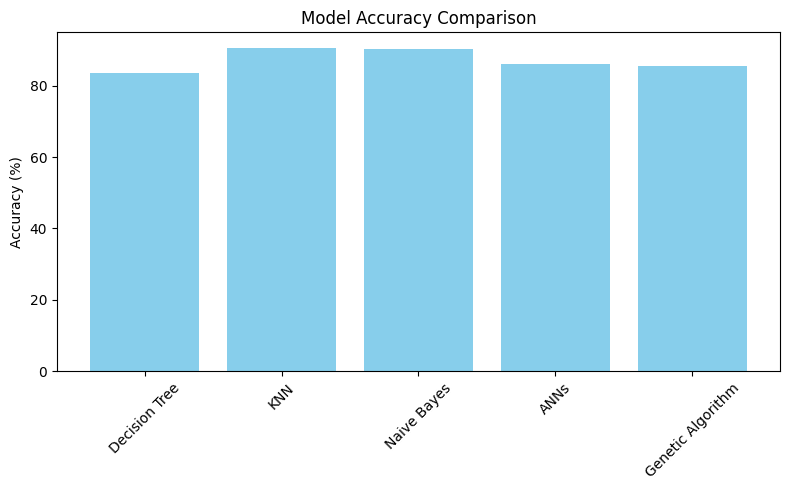

In [ ]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy_scores, color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

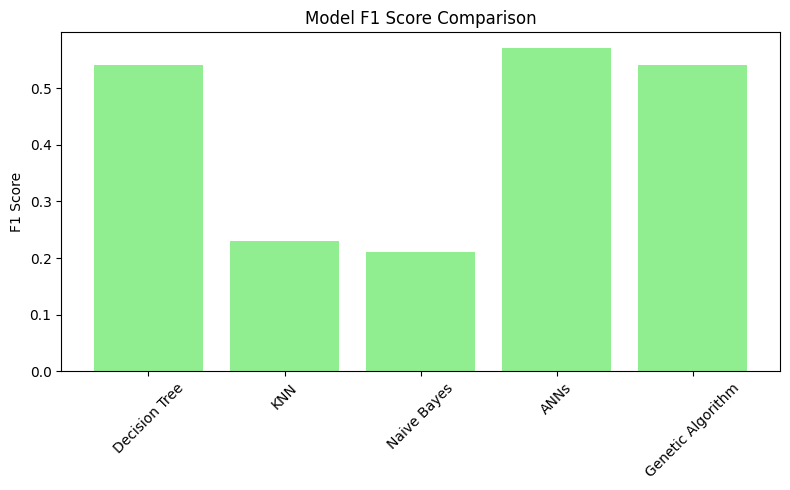

In [ ]:
# F1 Score
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color='lightgreen')
plt.title("Model F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

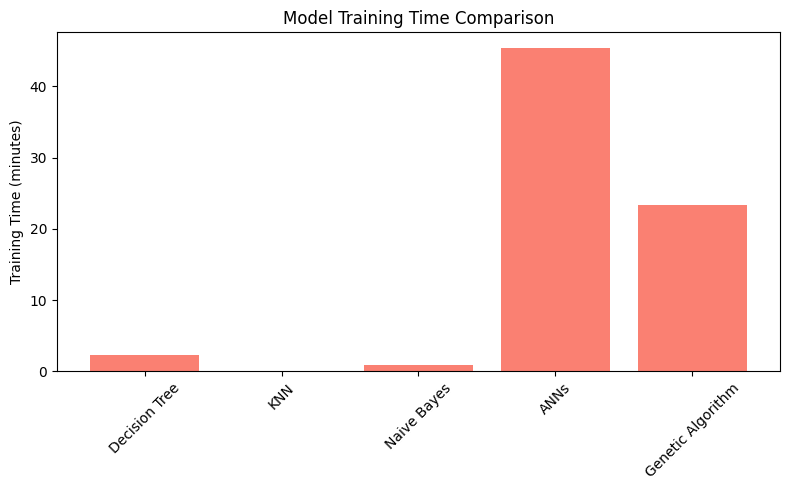

In [ ]:
# Training Time
plt.figure(figsize=(8, 5))
plt.bar(models, training_times, color='salmon')
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

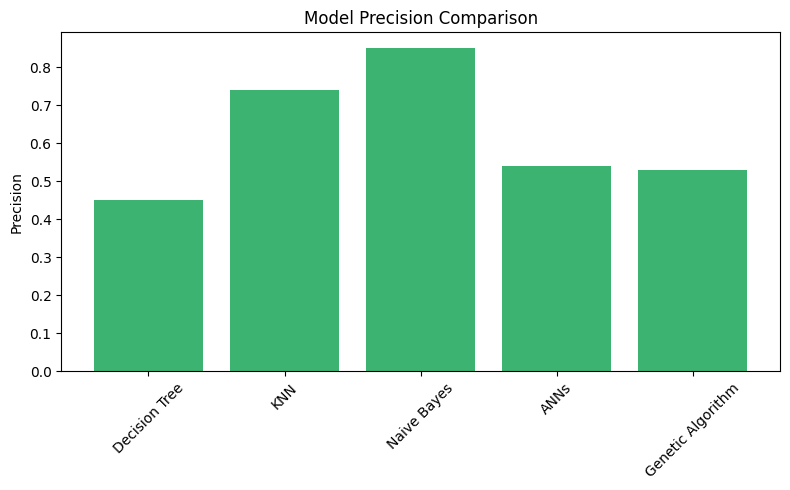

In [ ]:
# Precision
plt.figure(figsize=(8, 5))
plt.bar(models, precision_scores, color='mediumseagreen')
plt.title("Model Precision Comparison")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

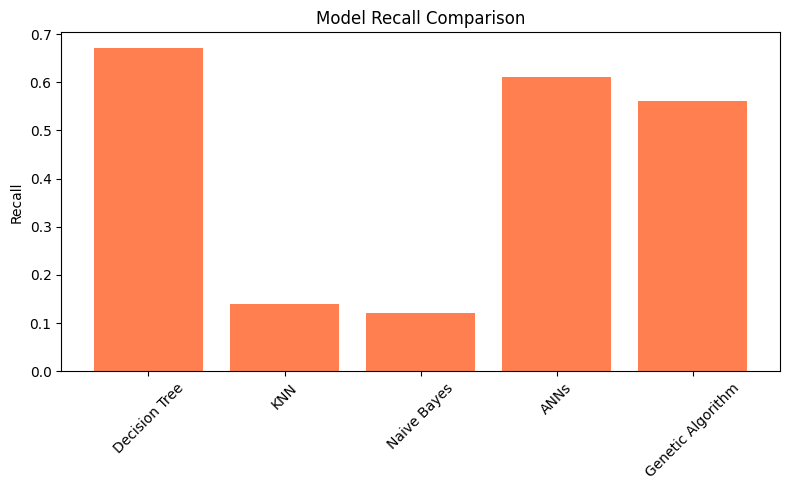

In [ ]:
# Recall
plt.figure(figsize=(8, 5))
plt.bar(models, recall_scores, color='coral')
plt.title("Model Recall Comparison")
plt.ylabel("Recall")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Model comparison dictionary
comparison_data = {
    "Model": models,
    "Accuracy (%)": accuracy_scores,
    "F1 Score (Weighted)": f1_scores,
    "Precision (Weighted)": precision_scores,
    "Recall (Weighted)": recall_scores,
    "Training Time (min)": training_times
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table
print(comparison_df)

               Model  Accuracy (%)  F1 Score (Weighted)  Precision (Weighted)  \
0      Decision Tree         83.57                 0.54                  0.45   
1                KNN         90.39                 0.23                  0.74   
2        Naive Bayes         90.32                 0.21                  0.85   
3               ANNs         85.95                 0.57                  0.54   
4  Genetic Algorithm         85.59                 0.54                  0.53   

   Recall (Weighted)  Training Time (min)  
0               0.67                 2.23  
1               0.14                 0.00  
2               0.12                 0.88  
3               0.61                45.34  
4               0.56                23.32  


## 10. Conclusion & Future Work

In this project, we developed a text classification system to detect toxic comments using natural language processing and machine learning techniques. We applied thorough text preprocessing, visualized patterns in toxic vs. non-toxic language, and trained multiple classifiers, including Decision Tree, Naive Bayes, Genetic Algorithm, ANNs, and KNN. To reduce memory usage and training time, the models were trained and evaluated on a random sample of 30,000 (instead of 150,000+) comments from the full dataset.

From the data, KNN achieved the highest accuracy (90.39%) with Naive Bayes close behind at 90.32%. However, ANNs produced the best F1 Score (0.57), indicating strong balance between precision and recall.

The model was trained and evaluated using TF-IDF features extracted from cleaned text, with visualization insights confirming that toxic comments tend to use more aggressive language and are slightly longer in length.

#### Future improvements may include:
* Using deep learning methods like LSTMs or transformers (e.g., BERT) to capture deeper semantic meaning  
* Applying spelling correction or context-aware preprocessing  
* Hosting the model as a REST API for live toxicity detection  
* Balancing the dataset or using class weighting to improve results on minority classes like `threat` or `identity_hate`  
* Exploring ensemble models to combine predictions from multiple classifiers

**Note:**
This notebook was re-run due to a dataset issue in the initial execution. As a result, some of the reported metrics (e.g., accuracy, precision) may slightly differ from the previous version. The overall approach, methodology, and implementation remain unchanged. We’ve double-checked the data and workflow to ensure that this version accurately reflects the intended results.

We appreciate your understanding and hope this does not affect our evaluation, as the variation stems from correcting the dataset and ensuring consistency in our process.

**Acknowledgment:**  
We would like to thank [Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) and the competition host, **Jigsaw/Conversation AI**, for providing the dataset and sharing this project through the Jigsaw Toxic Comment Classification Challenge. Their challenge helps us to explore real-world applications of toxic comment detection using machine learning.
